<a href="https://colab.research.google.com/github/mafaldasalomao/pavic_treinamento_ml/blob/main/PAVIC_ML_19_U_Net_Training_Image_Segmentation_Models_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net: Training Image Segmentation Models in PyTorch

Throughout this tutorial, we will be looking at image segmentation and building and training a segmentation model in PyTorch. We will focus on a very successful architecture, U-Net, which was originally proposed for medical image segmentation. Furthermore, we will understand the salient features of the U-Net model, which make it an apt choice for the task of image segmentation.

Specifically, we will discuss the following, in detail, in this tutorial:

The architectural details of U-Net that make it a powerful segmentation model
Creating a custom PyTorch Dataset for our image segmentation task
Training the U-Net segmentation model from scratch
Making predictions on novel images with our trained U-Net model



```
# .
├── dataset
│   └── train
├── output
├── pyimagesearch
│   ├── config.py
│   ├── dataset.py
│   └── model.py
├── predict.py
└── train.py
```



In [10]:
import os
if not os.path.exists('dataset'):
    !wget -q https://github.com/mafaldasalomao/pavic_treinamento_ml/raw/main/data/tgs-salt-identification-challenge/train.zip
    !mkdir /content/dataset/
    !unzip -q train.zip -d /content/dataset/train/
    !rm train.zip

In [12]:
import os

os.makedirs("pyimagesearch", exist_ok=True)
os.makedirs("output", exist_ok=True)

In [3]:
%%writefile pyimagesearch/config.py
# import the necessary packages
import torch
import os
# base path of the dataset
DATASET_PATH = os.path.join("dataset", "train")
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")
# define the test split
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
#U-Net: Training Image Segmentation Models in PyTorch
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64
# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

Writing pyimagesearch/config.py


We start by importing the necessary packages on Lines 2 and 3. Then, we define the path for our dataset (i.e., DATASET_PATH) on Line 6 and the paths for images and masks within the dataset folder (i.e., IMAGE_DATASET_PATH and MASK_DATASET_PATH) on Lines 9 and 10

On Line 13, we define the fraction of the dataset we will keep aside for the test set. Then, on Line 16, we define the DEVICE parameter, which determines based on availability, whether we will be using a GPU or CPU for training our segmentation model. In this case, we are using a CUDA-enabled GPU device, and we set the PIN_MEMORY parameter to True on Line 19.

Next, we define the NUM_CHANNELS, NUM_CLASSES, and NUM_LEVELS parameters on Lines 23-25, which we will discuss in more detail later in the tutorial. Finally, on Lines 29-31, we define the training parameters such as initial learning rate (i.e., INIT_LR), the total number of epochs (i.e., NUM_EPOCHS), and batch size (i.e., BATCH_SIZE).

On Lines 34 and 35, we also define input image dimensions to which our images should be resized for our model to process them. We further define a threshold parameter on Line 38, which will later help us classify the pixels into one of the two classes in our binary classification-based segmentation task.

Finally, we define the path to our output folder (i.e., BASE_OUTPUT) on Line 41 and the corresponding paths to the trained model weights, training plots, and test images within the output folder on Lines 45-47.

## Creating Our Custom Segmentation Dataset Class


Now that we have defined our initial configurations and parameters, we are ready to understand the custom dataset class we will be using for our segmentation dataset.

Let’s open the dataset.py file from the pyimagesearch folder in our project directory.

Let’s open the dataset.py file from the pyimagesearch folder in our project directory.

In [4]:
%%writefile pyimagesearch/dataset.py
# import the necessary packages
from torch.utils.data import Dataset
import cv2
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

Writing pyimagesearch/dataset.py


We begin by importing the Dataset class from the torch.utils.data module on Line 2. This is important since all PyTorch datasets must inherit from this base dataset class. Furthermore, on Line 3, we import the OpenCV package, which will enable us to use its image handling functionalities.

We are now ready to define our own custom segmentation dataset. Each PyTorch dataset is required to inherit from Dataset class (Line 5) and should have a __len__ (Lines 13-15) and a __getitem__ (Lines 17-34) method. We discuss each of these methods below.

We start by defining our initializer constructor, that is, the __init__ method on Lines 6-11. The method takes as input the list of image paths (i.e., imagePaths) of our dataset, the corresponding ground-truth masks (i.e., maskPaths), and the set of transformations (i.e., transforms) we want to apply to our input images (Line 6).

On Lines 9-11, we initialize the attributes of our SegmentationDataset class with the parameters input to the __init__ constructor.

Next, we define the __len__ method, which returns the total number of image paths in our dataset, as shown on Line 15.

The task of the __getitem__ method is to take an index as input (Line 17) and returns the corresponding sample from the dataset. On Line 19, we simply grab the image path at the idx index in our list of input image paths. Then, we load the image using OpenCV (Line 23). By default, OpenCV loads an image in the BGR format, which we convert to the RGB format as shown on Line 24. We also load the corresponding ground-truth segmentation mask in grayscale mode on Line 25.

Finally, we check for input transformations that we want to apply to our dataset images (Line 28) and transform both the image and mask with the required transforms on Lines 30 and 31, respectively. This is important since we want our image and ground-truth mask to correspond and have the same dimension. On Line 34, we return the tuple containing the image and its corresponding mask (i.e., (image, mask)) as shown.

This completes the definition of our custom Segmentation dataset. Next, we will discuss the implementation of the U-Net architecture.

## Building Our U-Net Model in PyTorch

It is time to look at our U-Net model architecture in detail and build it from scratch in PyTorch.

We open our model.py file from the pyimagesearch folder in our project directory and get started.

In [5]:
%%writefile pyimagesearch/model.py
# import the necessary packages
from . import config
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch
#U-Net: Training Image Segmentation Models in PyTorch
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))
#U-Net: Training Image Segmentation Models in PyTorch
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures
#U-Net: Training Image Segmentation Models in PyTorch
class UNet(Module):
  def __init__(self, encChannels=(3, 16, 32, 64),
	decChannels=(64, 32, 16),
	nbClasses=1, retainDim=True,
	outSize=(config.INPUT_IMAGE_HEIGHT,  config.INPUT_IMAGE_WIDTH)):
      super().__init__()
      # initialize the encoder and decoder
      self.encoder = Encoder(encChannels)
      self.decoder = Decoder(decChannels)
      # initialize the regression head and store the class variables
      self.head = Conv2d(decChannels[-1], nbClasses, 1)
      self.retainDim = retainDim
      self.outSize = outSize
  def forward(self, x):
      # grab the features from the encoder
      encFeatures = self.encoder(x)
      # pass the encoder features through decoder making sure that
      # their dimensions are suited for concatenation
      decFeatures = self.decoder(encFeatures[::-1][0],
        encFeatures[::-1][1:])
      # pass the decoder features through the regression head to
      # obtain the segmentation mask
      map = self.head(decFeatures)
      # check to see if we are retaining the original output
      # dimensions and if so, then resize the output to match them
      if self.retainDim:
        map = F.interpolate(map, self.outSize)
      # return the segmentation map
      return map

Writing pyimagesearch/model.py


## Training Our Segmentation Model


Now that we have implemented our dataset class and model architecture, we are ready to construct and train our segmentation pipeline in PyTorch. Let’s open the train.py file from our project directory.

Specifically, we will be looking at the following in detail:

Structuring the data-loading pipeline
Initializing the model and training parameters
Defining the training loop
Visualizing the training and test loss curves

In [6]:
%%writefile train.py
# USAGE
# python train.py
# import the necessary packages
from pyimagesearch.dataset import SegmentationDataset
from pyimagesearch.model import UNet
from pyimagesearch import config
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os


# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=config.TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((config.INPUT_IMAGE_HEIGHT,
		config.INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

# initialize our UNet model
unet = UNet().to(config.DEVICE)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=config.INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // config.BATCH_SIZE
testSteps = len(testDS) // config.BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}


# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
# serialize the model to disk
torch.save(unet, config.MODEL_PATH)

Writing train.py


In [13]:
!python train.py

[INFO] saving testing image paths...
[INFO] found 3400 examples in the training set...
[INFO] found 600 examples in the test set...
[INFO] training the network...
  0% 0/40 [00:00<?, ?it/s][INFO] EPOCH: 1/40
Train loss: 0.604586, Test loss: 0.6081
  2% 1/40 [00:16<10:34, 16.27s/it][INFO] EPOCH: 2/40
Train loss: 0.560459, Test loss: 0.5434
  5% 2/40 [00:22<06:36, 10.43s/it][INFO] EPOCH: 3/40
Train loss: 0.514477, Test loss: 0.5014
  8% 3/40 [00:29<05:31,  8.97s/it][INFO] EPOCH: 4/40
Train loss: 0.458320, Test loss: 0.4595
 10% 4/40 [00:36<04:56,  8.22s/it][INFO] EPOCH: 5/40
Train loss: 0.417873, Test loss: 0.4882
 12% 5/40 [00:44<04:41,  8.04s/it][INFO] EPOCH: 6/40
Train loss: 0.407437, Test loss: 0.4041
 15% 6/40 [00:50<04:10,  7.35s/it][INFO] EPOCH: 7/40
Train loss: 0.402195, Test loss: 0.4394
 18% 7/40 [00:57<04:00,  7.29s/it][INFO] EPOCH: 8/40
Train loss: 0.392281, Test loss: 0.4145
 20% 8/40 [01:03<03:38,  6.83s/it][INFO] EPOCH: 9/40
Train loss: 0.382555, Test loss: 0.4009
 22% 9/4

## Using Our Trained U-Net Model for Prediction

Once we have trained and saved our segmentation model, we are ready to see it in action and use it for segmentation tasks.

Open the predict.py file from our project directory.

[INFO] loading up test image paths...
[INFO] load up model...


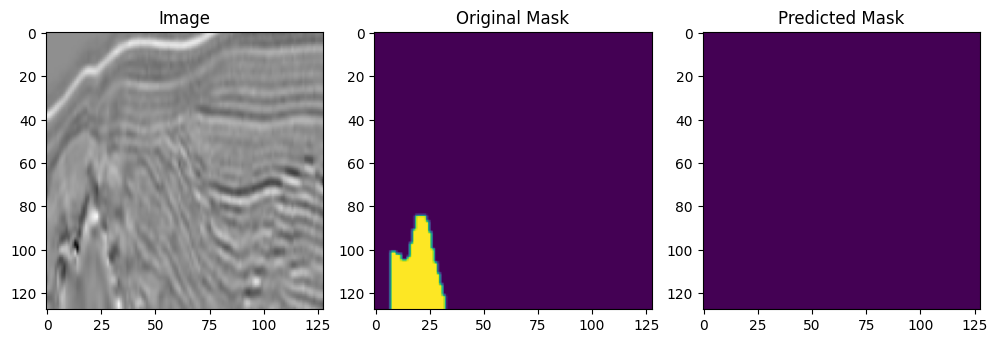

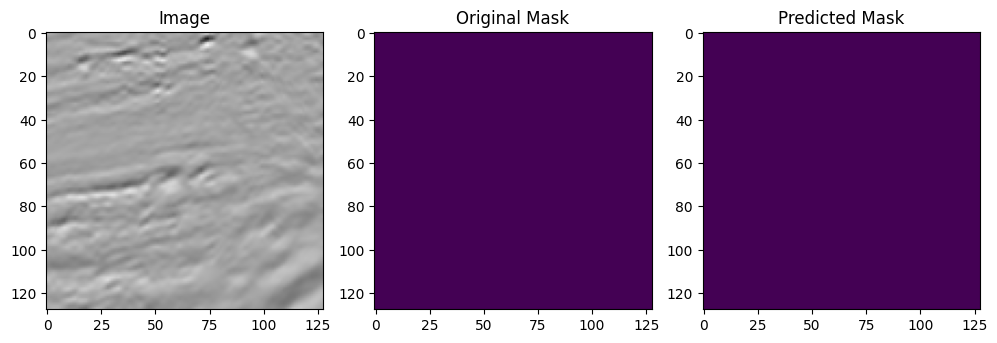

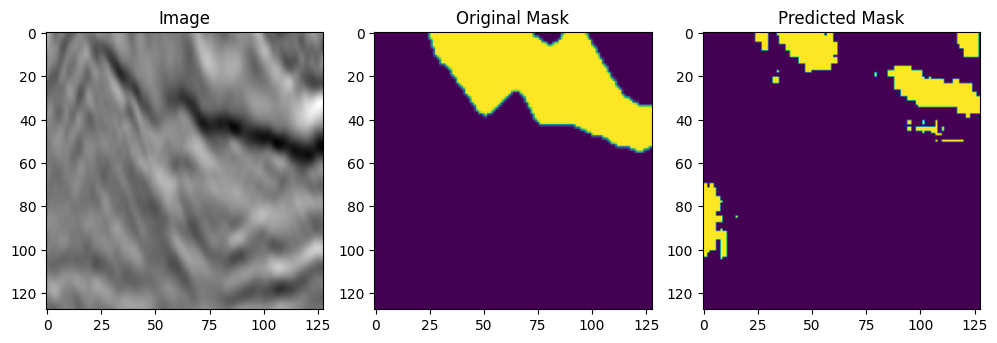

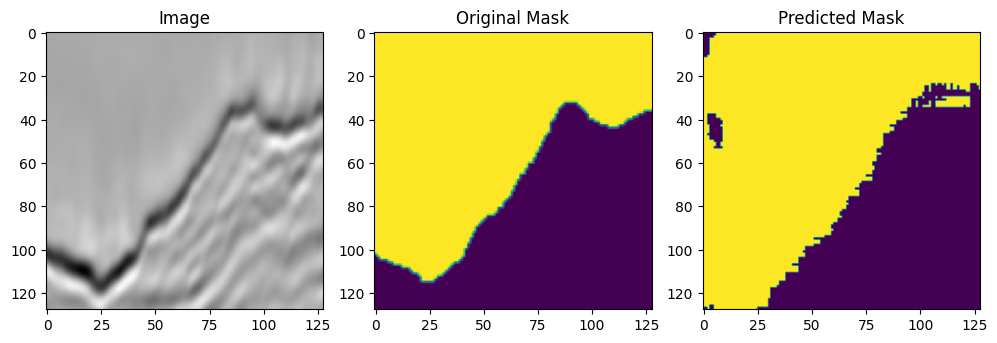

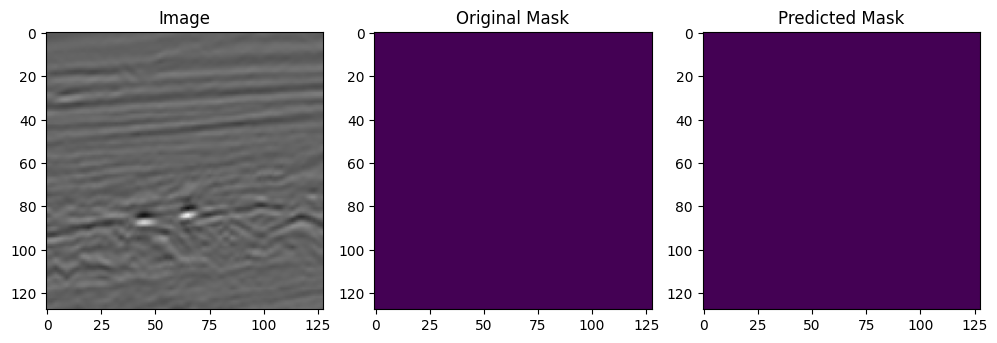

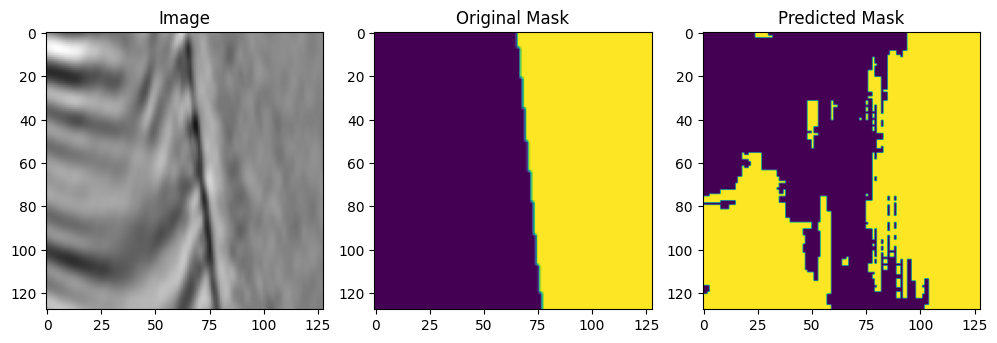

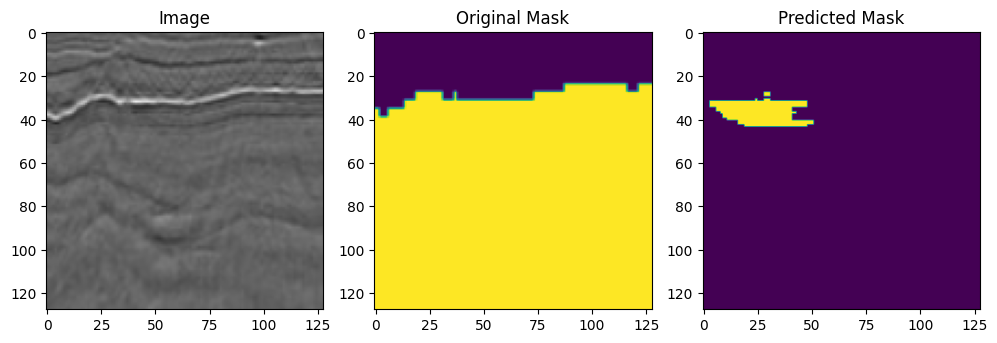

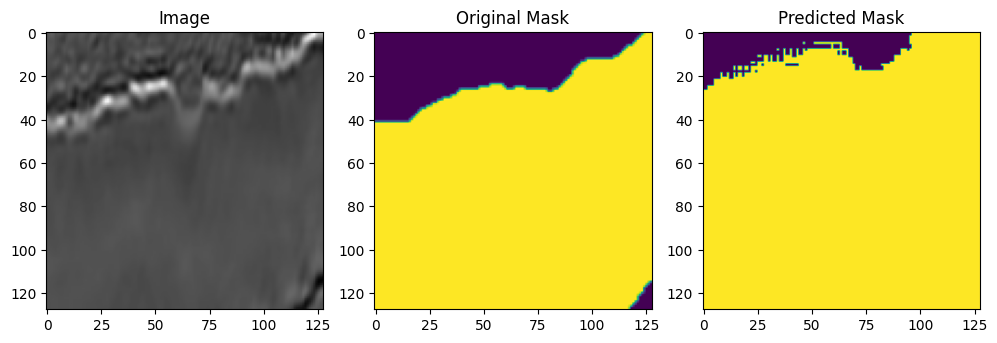

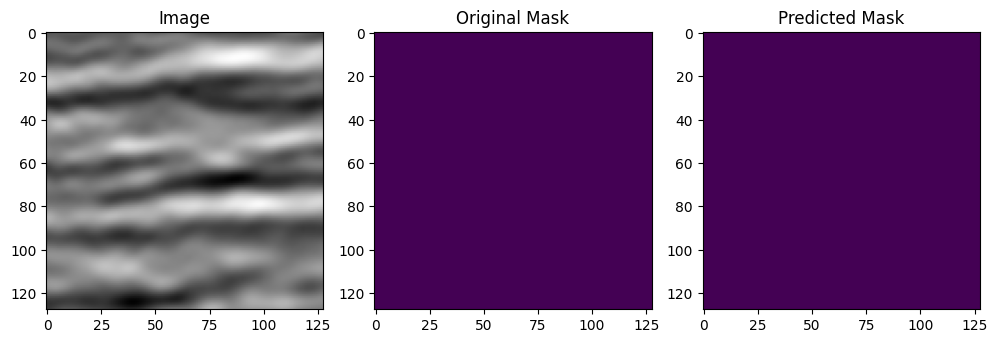

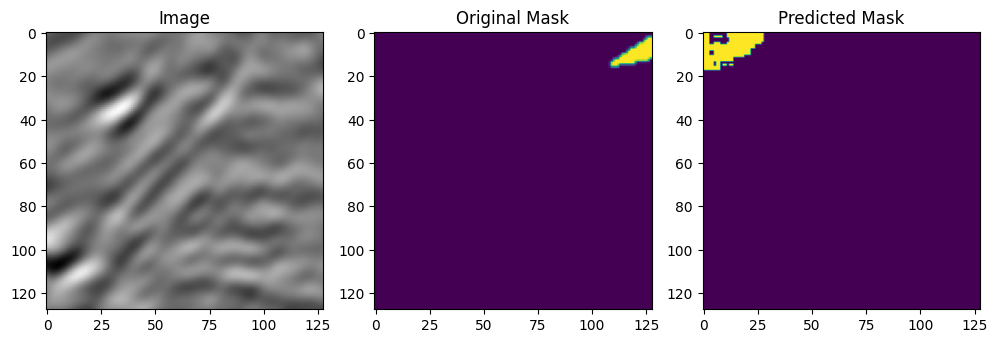

In [22]:

# USAGE
# python predict.py
# import the necessary packages
from pyimagesearch import config
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (128, 128))
        orig = image.copy()
        # find the filename and generate the path to ground truth
        # mask
        filename = imagePath.split(os.path.sep)[-1]
        groundTruthPath = os.path.join(config.MASK_DATASET_PATH,
          filename)
        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = cv2.imread(groundTruthPath, 0)
        gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT,
          config.INPUT_IMAGE_HEIGHT))

        #U-Net: Training Image Segmentation Models in PyTorch
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(config.DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > config.THRESHOLD) * 255
        predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask)
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(config.TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)


[Arquivo completo](https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/)


[Dataset](https://www.kaggle.com/competitions/tgs-salt-identification-challenge/data?select=train.zip)